In [1]:
# For One-Dimensional Ornstein-Uhlenbeck (OU) Process Experiments

import os, sys, numpy as np, time, random
import matplotlib.pyplot as plt

# Set up module paths (adjust as needed)
notebooks_path = os.path.abspath(os.getcwd())
src_path = os.path.abspath(os.path.join(notebooks_path, "../src"))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Import custom functions (including the markovian solvers and tree visualization)
from optimal_code.utils import *
from optimal_code.optimal_solver import *
from optimal_code.optimal_solver_markov import *
from trees.build_trees_from_paths import *
from trees.treeVisualization import *
from adapted_empirical_measure.AEM_grid import *

In [2]:
def ou_simulation(n_sample, T, mu, sigma, dt, seed):
    """
    Simulates an Ornstein-Uhlenbeck process with SDE:
        dX_t = (X_t - mu) dt + sigma dW_t
    using the Euler-Maruyama discretization.
    
    Parameters:
      n_sample : int
          Number of sample paths.
      T : int
          Number of time steps.
      mu : float
          Parameter mu (here used as the 'mean level' in the drift).
      sigma : float
          Volatility coefficient.
      dt : float
          Time step length (in annualized units).
      seed : int
          Random seed.
    
    Returns:
      X : np.ndarray
          Array of shape (T+1, n_sample) containing the simulated paths.
    """
    np.random.seed(seed)
    X = np.zeros((T+1, n_sample))
    # For OU, we set the initial condition at mu (or any chosen starting value)
    X[0, :] = mu  
    for t in range(1, T+1):
        Z = np.random.normal(size=n_sample)
        X[t, :] = X[t-1, :] + (X[t-1, :] - mu) * dt + sigma * np.sqrt(dt) * Z
    return X

## Same parameters as for BS:

Does it make sens to use the same?

In [3]:
# ---------------------------------------------------------------------------
# Simulation Settings for a 1-Month Option (30 Days)
# ---------------------------------------------------------------------------

T = 30             # 30 time steps (days)
dt = 1 / 365       # each time step represents one day (annualized time)

# Parameters for process X (less volatile OU process)
mu1 = 1.0          # 'mean' level (also used as the initial condition)
sigma1 = 0.15      # lower volatility

# Parameters for process Y (more volatile OU process)
mu2 = 1.0          # same mean level for comparison
sigma2 = 0.50      # higher volatility

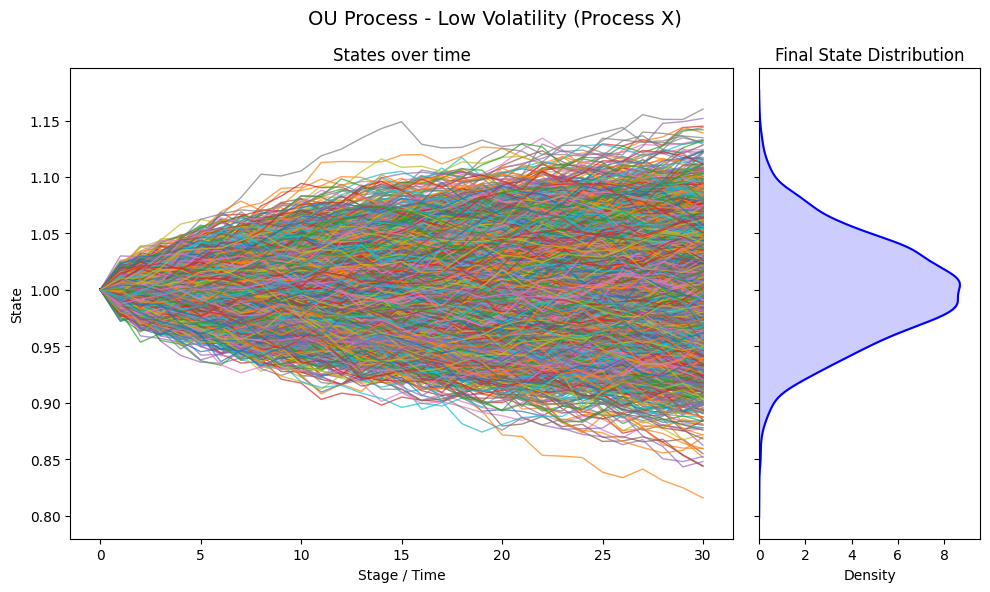

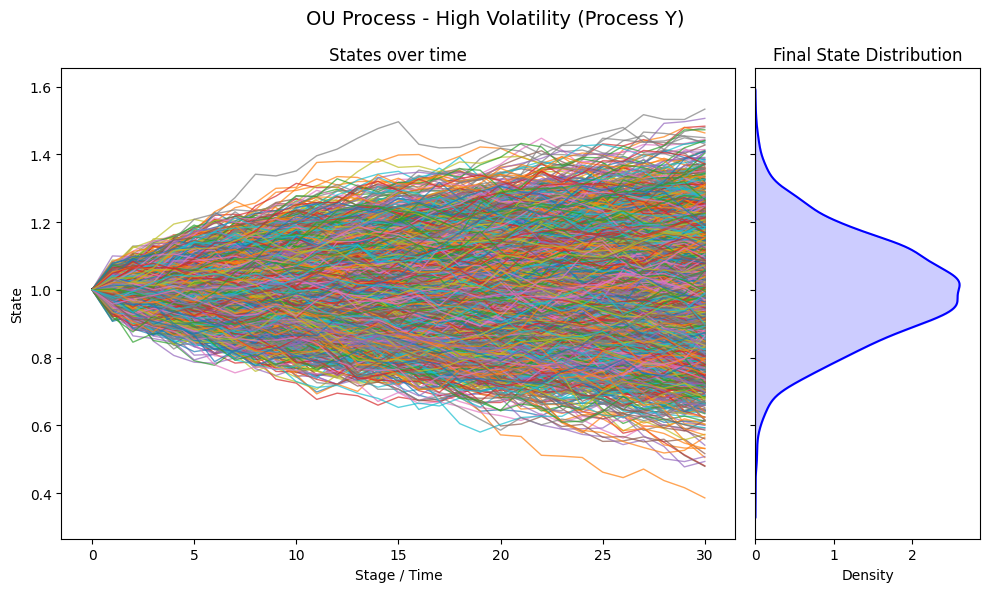

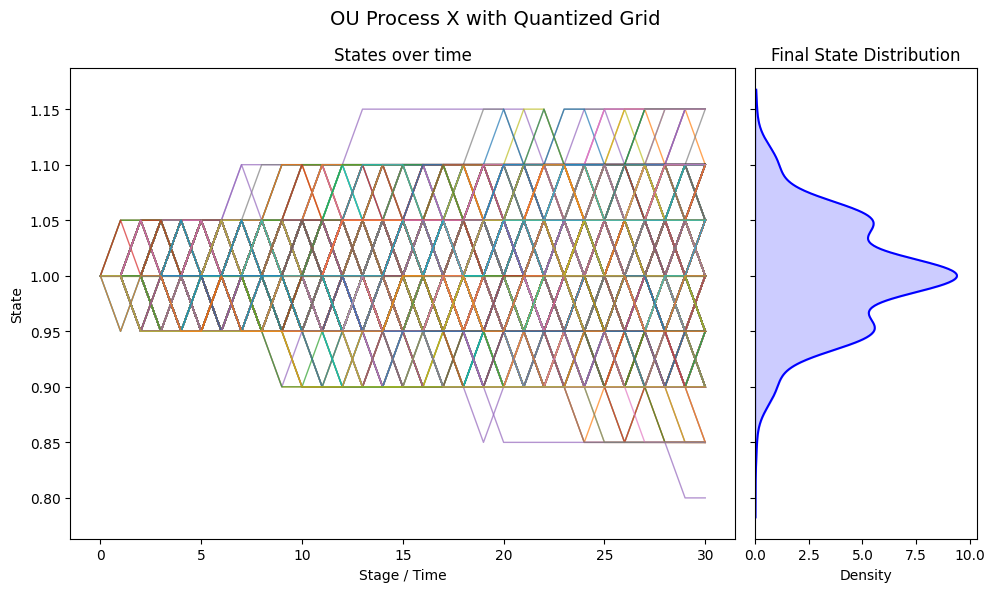

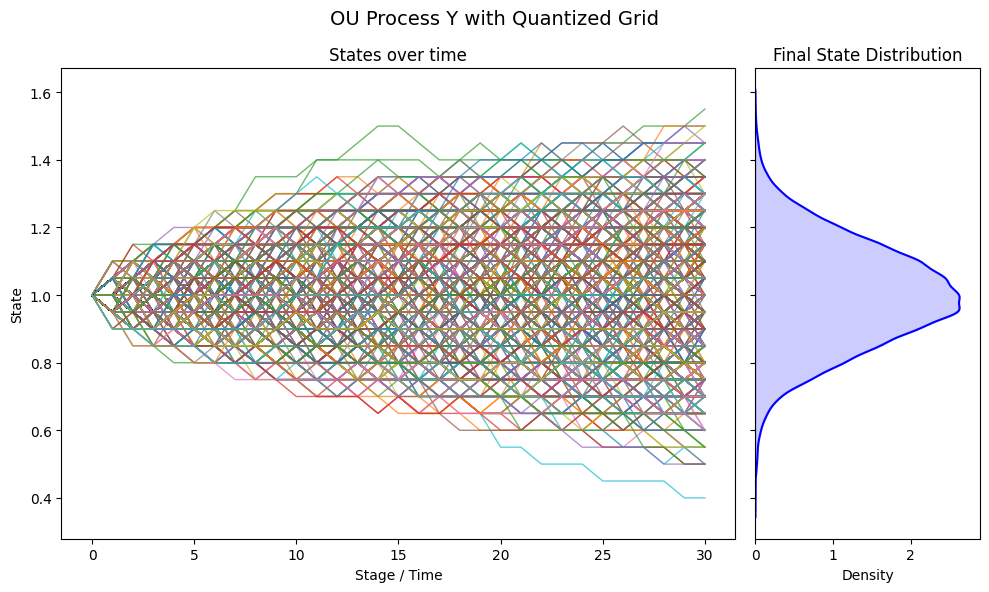

In [4]:
# ---------------------------------------------------------------------------
# Visualizing the Trees for OU Processes
# ---------------------------------------------------------------------------

n_sample = 5000
seed = 44

# Simulate OU processes for both assets
X = ou_simulation(n_sample, T, mu1, sigma1, dt, seed)
Y = ou_simulation(n_sample, T, mu2, sigma2, dt, seed)

# Uniform weights for tree building
iid_weights = np.full(n_sample, 1 / n_sample)

# Build and visualize tree for process X
root = build_tree_from_paths(X.T, iid_weights)
visualize_big_tree(
    root,
    fig_size=(10, 6),
    title="OU Process - Low Volatility (Process X)",
)

# Build and visualize tree for process Y
root = build_tree_from_paths(Y.T, iid_weights)
visualize_big_tree(
    root,
    fig_size=(10, 6),
    title="OU Process - High Volatility (Process Y)",
)

# Now apply grid quantization
fixed_grid = 0.05

new_sample_paths, new_weights = uniform_empirical_grid_measure(X.T, fixed_grid, use_weights=True)
root = build_tree_from_paths(new_sample_paths, new_weights)
visualize_big_tree(
    root,
    fig_size=(10, 6),
    title="OU Process X with Quantized Grid",
)

new_sample_paths, new_weights = uniform_empirical_grid_measure(Y.T, fixed_grid, use_weights=True)
root = build_tree_from_paths(new_sample_paths, new_weights)
visualize_big_tree(
    root,
    fig_size=(10, 6),
    title="OU Process Y with Quantized Grid",
)

In [5]:
# ---------------------------------------------------------------------------
# Running Experiments with Varying Sample Sizes
# ---------------------------------------------------------------------------

sample_sizes = [1000, 2000, 5000, 10000, 20000, 30000]  # Computational budget
n_runs = 10

results = {}

for n_sample in sample_sizes:
    distances_runs = np.zeros(n_runs)
    times_runs = np.zeros(n_runs)
    
    print(f"\nRunning experiments for sample size: {n_sample}")
    
    for run in range(n_runs):
        # Generate an independent seed for each run
        seed = np.random.randint(10000)
        
        # Simulate the OU processes for both assets
        X = ou_simulation(n_sample, T, mu1, sigma1, dt, seed)
        Y = ou_simulation(n_sample, T, mu2, sigma2, dt, seed)
        
        # Convert to adapted paths using grid quantization
        adaptedX = path2adaptedpath(X, delta_n=fixed_grid)
        adaptedY = path2adaptedpath(Y, delta_n=fixed_grid)
        
        # Build quantization mapping
        q2v = np.unique(np.concatenate([adaptedX, adaptedY], axis=0))
        v2q = {k: v for v, k in enumerate(q2v)}
        qX = np.array([[v2q[x] for x in y] for y in adaptedX])
        qY = np.array([[v2q[x] for x in y] for y in adaptedY])
        qX = sort_qpath(qX.T)
        qY = sort_qpath(qY.T)
        
        # Build conditional measures (markovian)
        mu_x = qpath2mu_x(qX, markovian=True)
        nu_y = qpath2mu_x(qY, markovian=True)
        
        # Updated list representations now return 7 items:
        (mu_x_c, mu_x_cn, mu_x_v, mu_x_w, mu_x_cumn, v2q_x, mu_x_idx) = \
            list_repr_mu_x_markovian(mu_x, q2v)
        (nu_y_c, nu_y_cn, nu_y_v, nu_y_w, nu_y_cumn, v2q_y, nu_y_idx) = \
            list_repr_mu_x_markovian(nu_y, q2v)
        
        # Compute adapted Wasserstein squared distance using the parallel solver
        t_start = time.perf_counter()
        AW_2square = nested2_parallel_markovian(mu_x_cn, mu_x_v, mu_x_w, mu_x_idx,
                                                nu_y_cn, nu_y_v, nu_y_w, nu_y_idx,
                                                n_processes=42)
        elapsed = time.perf_counter() - t_start
        
        distances_runs[run] = AW_2square
        times_runs[run] = elapsed
        
        print(f"Run {run+1}: AW_2^2 = {AW_2square:.4f}, Time = {elapsed:.4f}s")
    
    results[n_sample] = {"distances": distances_runs, "times": times_runs}


Running experiments for sample size: 1000
Run 1: AW_2^2 = 0.2705, Time = 10.3836s
Run 2: AW_2^2 = 0.2795, Time = 11.5080s
Run 3: AW_2^2 = 0.2634, Time = 10.7838s
Run 4: AW_2^2 = 0.2562, Time = 10.9075s
Run 5: AW_2^2 = 0.2595, Time = 11.0791s
Run 6: AW_2^2 = 0.2833, Time = 11.2090s
Run 7: AW_2^2 = 0.2567, Time = 11.1069s
Run 8: AW_2^2 = 0.2756, Time = 10.6627s
Run 9: AW_2^2 = 0.2610, Time = 11.9539s
Run 10: AW_2^2 = 0.2865, Time = 10.9685s

Running experiments for sample size: 2000
Run 1: AW_2^2 = 0.2662, Time = 11.6793s
Run 2: AW_2^2 = 0.2588, Time = 11.9068s
Run 3: AW_2^2 = 0.2668, Time = 11.8819s
Run 4: AW_2^2 = 0.2639, Time = 12.0592s
Run 5: AW_2^2 = 0.2687, Time = 11.5037s
Run 6: AW_2^2 = 0.2667, Time = 10.2158s
Run 7: AW_2^2 = 0.2842, Time = 10.1981s
Run 8: AW_2^2 = 0.2746, Time = 10.3425s
Run 9: AW_2^2 = 0.2695, Time = 10.2625s
Run 10: AW_2^2 = 0.2653, Time = 10.2479s

Running experiments for sample size: 5000
Run 1: AW_2^2 = 0.2648, Time = 10.2605s
Run 2: AW_2^2 = 0.2718, Time 

## Goes faster with more samples -> overhard speed I think but of course more computations for larger sample size

Sample Size: 1000
  Mean AW_2^2: 0.2692 ± 0.0108
  Mean Time: 11.0563s ± 0.4180s

Sample Size: 2000
  Mean AW_2^2: 0.2685 ± 0.0065
  Mean Time: 11.0298s ± 0.7892s

Sample Size: 5000
  Mean AW_2^2: 0.2681 ± 0.0037
  Mean Time: 10.2142s ± 0.1748s

Sample Size: 10000
  Mean AW_2^2: 0.2652 ± 0.0032
  Mean Time: 10.0912s ± 0.0838s

Sample Size: 20000
  Mean AW_2^2: 0.2660 ± 0.0028
  Mean Time: 10.2128s ± 0.0913s

Sample Size: 30000
  Mean AW_2^2: 0.2656 ± 0.0021
  Mean Time: 10.1947s ± 0.1563s



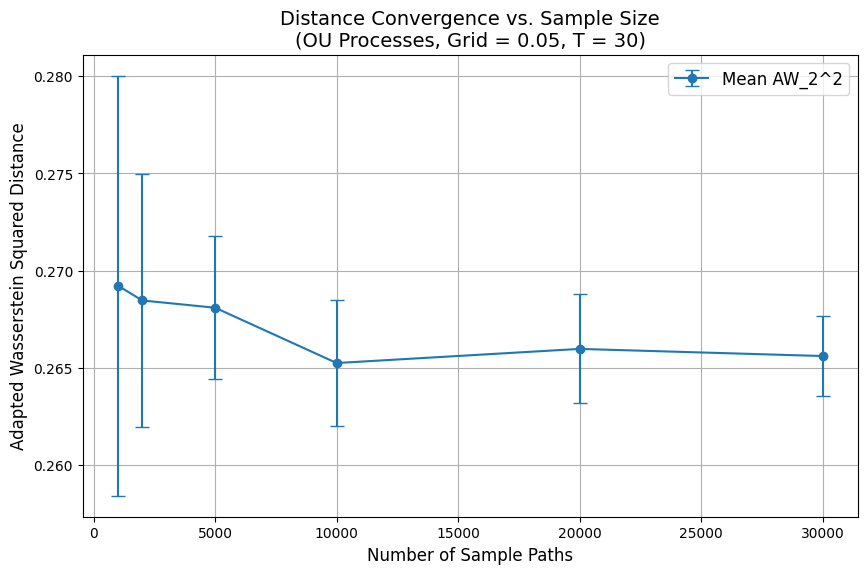

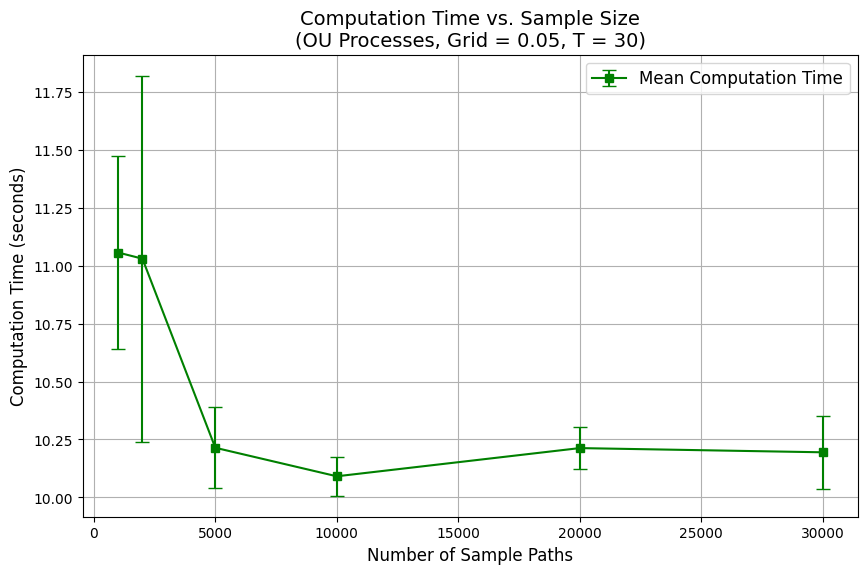

In [6]:
# ---------------------------------------------------------------------------
# Plotting Convergence and Computation Time
# ---------------------------------------------------------------------------

aggregated = {}
for n_sample in sorted(results.keys()):
    dists = results[n_sample]["distances"]
    times = results[n_sample]["times"]
    mean_dist = np.mean(dists)
    std_dist = np.std(dists)
    mean_time = np.mean(times)
    std_time = np.std(times)
    aggregated[n_sample] = {
        "mean_distance": mean_dist,
        "std_distance": std_dist,
        "mean_time": mean_time,
        "std_time": std_time
    }
    print(f"Sample Size: {n_sample}")
    print(f"  Mean AW_2^2: {mean_dist:.4f} ± {std_dist:.4f}")
    print(f"  Mean Time: {mean_time:.4f}s ± {std_time:.4f}s\n")

samples = sorted(aggregated.keys())
mean_distances = [aggregated[n]["mean_distance"] for n in samples]
std_distances = [aggregated[n]["std_distance"] for n in samples]
mean_times = [aggregated[n]["mean_time"] for n in samples]
std_times = [aggregated[n]["std_time"] for n in samples]

# Plot 1: Adapted AW_2^2 vs. Sample Size
plt.figure(figsize=(10, 6))
plt.errorbar(samples, mean_distances, yerr=std_distances, fmt="o-", capsize=5, label="Mean AW_2^2")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Adapted Wasserstein Squared Distance", fontsize=12)
plt.title("Distance Convergence vs. Sample Size\n(OU Processes, Grid = 0.05, T = 30)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot 2: Computation Time vs. Sample Size
plt.figure(figsize=(10, 6))
plt.errorbar(samples, mean_times, yerr=std_times, fmt="s-", capsize=5, color="green", label="Mean Computation Time")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Computation Time (seconds)", fontsize=12)
plt.title("Computation Time vs. Sample Size\n(OU Processes, Grid = 0.05, T = 30)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()
